In [3]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers


In [17]:
driver_details = pd.read_csv('../../statefarm_dataset/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))



  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [18]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("../../statefarm_dataset/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "../../statefarm_dataset/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [19]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [20]:
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [6]:
# ## getting list of driver names

# D = []
# for features,labels,drivers in train_image:
#     D.append(drivers)

# ## Deduplicating drivers

# deduped = []

# for i in D:
#     if i not in deduped:
#         deduped.append(i)
    

# ## selecting random drivers for the validation set
# driv_selected = []
# import random
# driv_nums = random.sample(range(len(deduped)), 4)
# for i in driv_nums:
#     driv_selected.append(deduped[i])


In [21]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [22]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(18732, 224, 224, 3)


In [6]:
## Defining the input

from tensorflow.keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')



## The VGG model

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)

In [7]:
#Use the generated model 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 
x = GlobalAveragePooling2D()(output_vgg16_conv)
x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x = Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(inputs = vgg16_input, outputs = x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096  

### Running VGG with Image Aumentation

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import json
import datetime

checkpointer = ModelCheckpoint('logs_vgg16_all_layers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

log_dir="logs_vgg16_all_layers/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)



datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper, tensorboard_callback],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

model_json = vgg16_pretrained.to_json()
with open("model_vgg16_all_layers.json",'w') as json_file:
 	json_file.write(model_json)

vgg16_pretrained.save_weights("model_vgg16_all_layers.h5")
print("Model saved")


Epoch 1/25
292/292 [============================>.] - ETA: 0s - loss: 2.7830 - accuracy: 0.1174
Epoch 00001: val_loss improved from inf to 2.41348, saving model to logs_vgg16_all_layers.hdf5
293/292 [==============================] - 410s 1s/step - loss: 2.7820 - accuracy: 0.1177 - val_loss: 2.4135 - val_accuracy: 0.2010
Epoch 2/25
292/292 [============================>.] - ETA: 0s - loss: 2.3689 - accuracy: 0.1964
Epoch 00002: val_loss improved from 2.41348 to 1.66366, saving model to logs_vgg16_all_layers.hdf5
293/292 [==============================] - 188s 643ms/step - loss: 2.3680 - accuracy: 0.1968 - val_loss: 1.6637 - val_accuracy: 0.4006
Epoch 3/25
292/292 [============================>.] - ETA: 0s - loss: 1.7065 - accuracy: 0.4048
Epoch 00003: val_loss improved from 1.66366 to 0.97554, saving model to logs_vgg16_all_layers.hdf5
293/292 [==============================] - 185s 631ms/step - loss: 1.7055 - accuracy: 0.4053 - val_loss: 0.9755 - val_accuracy: 0.6506
Epoch 4/25
292/29

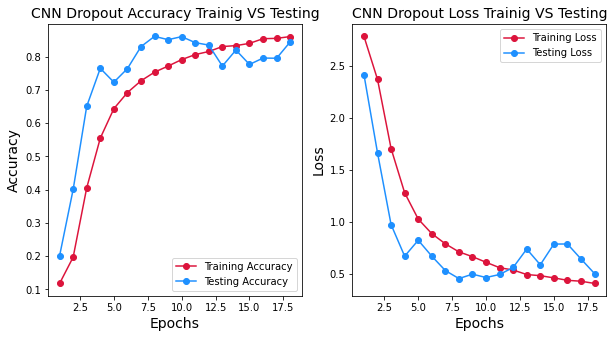

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


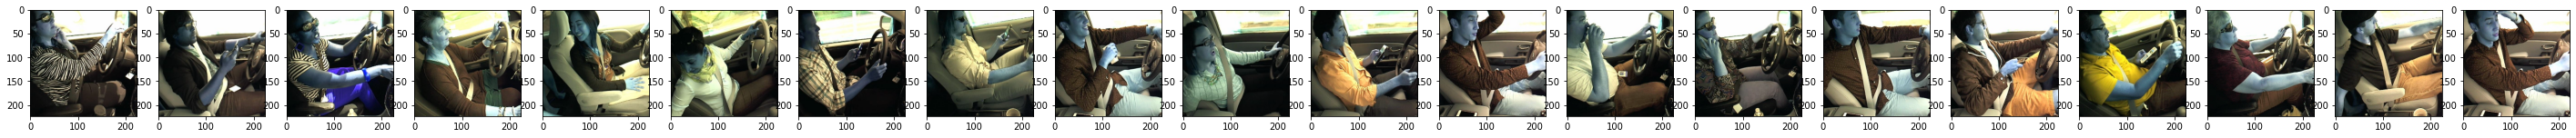

In [8]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('../../statefarm_dataset/test')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('../../statefarm_dataset/test/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show


In [9]:
from tensorflow.keras.models import model_from_json

test = []

for img in test_image:
    test.append(img)


vgg16_pretrained.load_weights('model_vgg16_all_layers.h5')


predict_test = np.array(test).reshape(-1,224,224,3).astype('float32')
prediction = vgg16_pretrained.predict(predict_test)

In [10]:
prediction[0]

array([2.2187064e-04, 4.4937310e-06, 5.5455860e-07, 1.3404594e-04,
       9.5959163e-01, 1.2274724e-07, 1.3563754e-04, 6.8429724e-04,
       3.6943372e-02, 2.2839154e-03], dtype=float32)

In [11]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

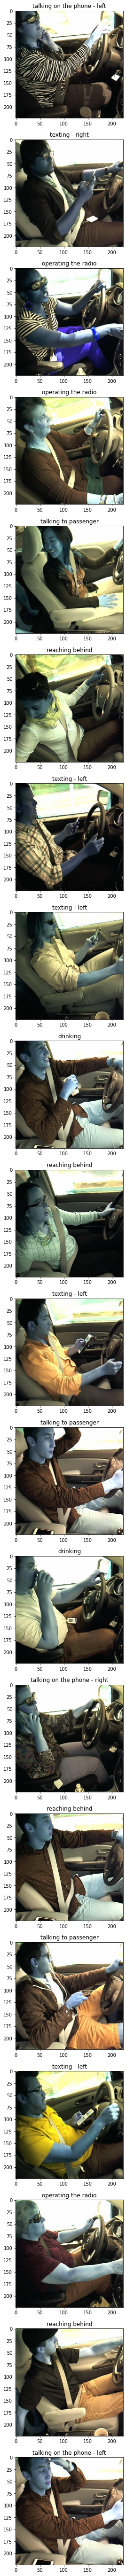

In [12]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i])
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    


# MobileNet Model

In [23]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
# base_model.summary()

x=base_model.output
x=GlobalAveragePooling2D()(x)

# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.

# x = Dropout(0.1)(x) # ****reduce dropout 

# x=Dense(1024,activation='relu')(x) #dense layer 2

# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(10,activation='softmax')(x) #final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [24]:

#adam = optimizers.Adam(lr=0.001) #tried 0.0005 - too slow and didn't converge
sgd = optimizers.SGD(lr = 0.005) # try 0.01 - didn't converge and 0.005 , 0.001 best acc of 11%

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) # create object


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import json
import datetime

checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

log_dir="logs_mobilenet_sgd_nolayers/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper, tensorboard_callback],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

model_json = model.to_json()
with open("mobilenet_sgd_nolayers.json",'w') as json_file:
 	json_file.write(model_json)

model.save_weights("mobilenet_sgd_nolayerss.h5")
print("Model saved")


Epoch 1/25
292/292 [============================>.] - ETA: 1s - loss: 1.8413 - accuracy: 0.3703
Epoch 00001: val_loss improved from inf to 1.04294, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 641s 2s/step - loss: 1.8396 - accuracy: 0.3712 - val_loss: 1.0429 - val_accuracy: 0.6641
Epoch 2/25
292/292 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.6705
Epoch 00002: val_loss improved from 1.04294 to 0.57622, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 176s 601ms/step - loss: 1.0392 - accuracy: 0.6705 - val_loss: 0.5762 - val_accuracy: 0.7963
Epoch 3/25
292/292 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.7423
Epoch 00003: val_loss improved from 0.57622 to 0.45499, saving model to mobilenet_sgd_nolayers.hdf5
293/292 [==============================] - 180s 613ms/step - loss: 0.7838 - accuracy: 0.7424 - val_loss: 0.4550 - val_accuracy: 0.8410
Epoch 4/25
292

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')